<a href="https://colab.research.google.com/github/Chakazul/evojax/blob/main/examples/notebooks/LeniaEvoJAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import
!pip install evojax
import google.colab
google.colab.output.clear()

import evojax
import jax
import jax.numpy as jnp
import numpy as np
from collections import namedtuple
from functools import partial
import copy
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display

print('Devices:\n', '\n'.join([d.device_kind for d in jax.devices()]))


Devices:
 NVIDIA A100-SXM4-40GB


In [ ]:
#@title Settings

# gene related
n_params_size = 3
n_cells_size = 30
n_kernel = 15  # k
n_channel = 3  # c
n_params = n_params_size * n_kernel  # 3*k
n_cells = n_cells_size * n_cells_size * n_channel  # e*e*c
n_gene = n_params + n_cells

# world related
world_size = 128
world_scale = 2
# world_size = 1024
# world_scale = 3

# simulation related
n_sim = 200
n_anim_step = 5

# evo algo related
n_population = 128
n_iteration = 30
n_interval = 1

print("global n_params_size, n_cells_size, n_kernel, n_channel, n_params, n_cells, n_gene, \\")
print("    world_size, world_scale, n_sim, n_anim_step, n_population, n_iteration, n_interval")


global n_params_size, n_cells_size, n_kernel, n_channel, n_params, n_cells, n_gene, \
    world_size, world_scale, n_sim, n_anim_step, n_population, n_iteration, n_interval


In [ ]:
#@title Utils

def display_array(A, title, cmap='viridis'):
  plt.imshow(A, cmap=cmap, interpolation="nearest")
  plt.title(title)
  plt.show()

def display_video(A, title=None, step=n_anim_step, cmap='viridis'):
  fig = plt.figure(figsize=(4,4), dpi=75, frameon=False)
  img = plt.imshow(A[0], cmap=cmap, interpolation="nearest", vmin=0)
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
  if title is not None:
    title = fig.text(0.05, 0.95, title, bbox={'facecolor':'w', 'alpha':0.5, 'pad':5}, ha="left")
  plt.close()
  def animate(i):
    # title.set_text(str(i))
    img.set_data(A[i*step])
  anim = matplotlib.animation.FuncAnimation(fig, animate, frames=A.shape[0]//step, interval=20)
  video = IPython.display.HTML(anim.to_html5_video())
  IPython.display.display(video)

Carry = namedtuple('Carry', [ 'world', 'param', 'asset', 'center' ])
Accum = namedtuple('Accum', [ 'world', 'stats' ])
Param = namedtuple('Params', [ 'm', 's', 'h' ])
Asset = namedtuple('Asset', [ 'fK', 'X', 'reshape_c_k', 'reshape_k_c', 'R', 'T' ])
Center = namedtuple('Center', [ 'last_center', 'last_shift', 'total_shift' ])
Stats = namedtuple('Stats', [ 'center_x', 'center_y', 'speed', 'is_empty', 'is_full' ])
Others = namedtuple('Others', [ 'D', 'K', 'cells', 'init_cells' ])


In [ ]:
#@title Patterns
patterns = {}
patterns["orbium"] = {"name":"Orbium","R":13,"T":10,"kernels":[
  {"b":[1],"m":0.15,"s":0.015,"h":1,"r":1,"c0":0,"c1":0}],
  "cells":[[[0,0,0,0,0,0,0.1,0.14,0.1,0,0,0.03,0.03,0,0,0.3,0,0,0,0], [0,0,0,0,0,0.08,0.24,0.3,0.3,0.18,0.14,0.15,0.16,0.15,0.09,0.2,0,0,0,0], [0,0,0,0,0,0.15,0.34,0.44,0.46,0.38,0.18,0.14,0.11,0.13,0.19,0.18,0.45,0,0,0], [0,0,0,0,0.06,0.13,0.39,0.5,0.5,0.37,0.06,0,0,0,0.02,0.16,0.68,0,0,0], [0,0,0,0.11,0.17,0.17,0.33,0.4,0.38,0.28,0.14,0,0,0,0,0,0.18,0.42,0,0], [0,0,0.09,0.18,0.13,0.06,0.08,0.26,0.32,0.32,0.27,0,0,0,0,0,0,0.82,0,0], [0.27,0,0.16,0.12,0,0,0,0.25,0.38,0.44,0.45,0.34,0,0,0,0,0,0.22,0.17,0], [0,0.07,0.2,0.02,0,0,0,0.31,0.48,0.57,0.6,0.57,0,0,0,0,0,0,0.49,0], [0,0.59,0.19,0,0,0,0,0.2,0.57,0.69,0.76,0.76,0.49,0,0,0,0,0,0.36,0], [0,0.58,0.19,0,0,0,0,0,0.67,0.83,0.9,0.92,0.87,0.12,0,0,0,0,0.22,0.07], [0,0,0.46,0,0,0,0,0,0.7,0.93,1,1,1,0.61,0,0,0,0,0.18,0.11], [0,0,0.82,0,0,0,0,0,0.47,1,1,0.98,1,0.96,0.27,0,0,0,0.19,0.1], [0,0,0.46,0,0,0,0,0,0.25,1,1,0.84,0.92,0.97,0.54,0.14,0.04,0.1,0.21,0.05], [0,0,0,0.4,0,0,0,0,0.09,0.8,1,0.82,0.8,0.85,0.63,0.31,0.18,0.19,0.2,0.01], [0,0,0,0.36,0.1,0,0,0,0.05,0.54,0.86,0.79,0.74,0.72,0.6,0.39,0.28,0.24,0.13,0], [0,0,0,0.01,0.3,0.07,0,0,0.08,0.36,0.64,0.7,0.64,0.6,0.51,0.39,0.29,0.19,0.04,0], [0,0,0,0,0.1,0.24,0.14,0.1,0.15,0.29,0.45,0.53,0.52,0.46,0.4,0.31,0.21,0.08,0,0], [0,0,0,0,0,0.08,0.21,0.21,0.22,0.29,0.36,0.39,0.37,0.33,0.26,0.18,0.09,0,0,0], [0,0,0,0,0,0,0.03,0.13,0.19,0.22,0.24,0.24,0.23,0.18,0.13,0.05,0,0,0,0], [0,0,0,0,0,0,0,0,0.02,0.06,0.08,0.09,0.07,0.05,0.01,0,0,0,0,0]]]
}

patterns["VT049W"] = {"name":"Aquarium (self-replicating)","R":12,"T":2,"kernels":[
  {"b":[1],"m":0.272,"s":0.0595,"h":0.138,"r":0.91,"c0":0,"c1":0},
  {"b":[1],"m":0.349,"s":0.1585,"h":0.48,"r":0.62,"c0":0,"c1":0},
  {"b":[1,1/4],"m":0.2,"s":0.0332,"h":0.284,"r":0.5,"c0":0,"c1":0},
  {"b":[0,1],"m":0.114,"s":0.0528,"h":0.256,"r":0.97,"c0":1,"c1":1},
  {"b":[1],"m":0.447,"s":0.0777,"h":0.5,"r":0.72,"c0":1,"c1":1},
  {"b":[5/6,1],"m":0.247,"s":0.0342,"h":0.622,"r":0.8,"c0":1,"c1":1},
  {"b":[1],"m":0.21,"s":0.0617,"h":0.35,"r":0.96,"c0":2,"c1":2},
  {"b":[1],"m":0.462,"s":0.1192,"h":0.218,"r":0.56,"c0":2,"c1":2},
  {"b":[1],"m":0.446,"s":0.1793,"h":0.556,"r":0.78,"c0":2,"c1":2},
  {"b":[11/12,1],"m":0.327,"s":0.1408,"h":0.344,"r":0.79,"c0":0,"c1":1},
  {"b":[3/4,1],"m":0.476,"s":0.0995,"h":0.456,"r":0.5,"c0":0,"c1":2},
  {"b":[11/12,1],"m":0.379,"s":0.0697,"h":0.67,"r":0.72,"c0":1,"c1":0},
  {"b":[1],"m":0.262,"s":0.0877,"h":0.42,"r":0.68,"c0":1,"c1":2},
  {"b":[1/6,1,0],"m":0.412,"s":0.1101,"h":0.43,"r":0.82,"c0":2,"c1":0},
  {"b":[1],"m":0.201,"s":0.0786,"h":0.278,"r":0.82,"c0":2,"c1":1}],
  "cells":[
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.49,1.0,0,0.03,0.49,0.49,0.28,0.16,0.03,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0.6,0.47,0.31,0.58,0.51,0.35,0.28,0.22,0,0,0,0,0], [0,0,0,0,0,0,0.15,0.32,0.17,0.61,0.97,0.29,0.67,0.59,0.88,1.0,0.92,0.8,0.61,0.42,0.19,0,0,0], [0,0,0,0,0,0,0,0.25,0.64,0.26,0.92,0.04,0.24,0.97,1.0,1.0,1.0,1.0,0.97,0.71,0.33,0.12,0,0], [0,0,0,0,0,0,0,0.38,0.84,0.99,0.78,0.67,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.95,0.62,0.37,0,0], [0,0,0,0,0.04,0.11,0,0.69,0.75,0.75,0.91,1.0,1.0,0.89,1.0,1.0,1.0,1.0,1.0,1.0,0.81,0.42,0.07,0], [0,0,0,0,0.44,0.63,0.04,0,0,0,0.11,0.14,0,0.05,0.64,1.0,1.0,1.0,1.0,1.0,0.92,0.56,0.23,0], [0,0,0,0,0.11,0.36,0.35,0.2,0,0,0,0,0,0,0.63,1.0,1.0,1.0,1.0,1.0,0.96,0.49,0.26,0], [0,0,0,0,0,0.4,0.37,0.18,0,0,0,0,0,0.04,0.41,0.52,0.67,0.82,1.0,1.0,0.91,0.4,0.23,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0,0.05,0.45,0.89,1.0,0.66,0.35,0.09,0], [0,0,0.22,0,0,0,0.05,0.36,0.6,0.13,0.02,0.04,0.24,0.34,0.1,0,0.04,0.62,1.0,1.0,0.44,0.25,0,0], [0,0,0,0.43,0.53,0.58,0.78,0.9,0.96,1.0,1.0,1.0,1.0,0.71,0.46,0.51,0.81,1.0,1.0,0.93,0.19,0.06,0,0], [0,0,0,0,0.23,0.26,0.37,0.51,0.71,0.89,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.42,0.06,0,0,0], [0,0,0,0,0.03,0,0,0.11,0.35,0.62,0.81,0.93,1.0,1.0,1.0,1.0,1.0,0.64,0.15,0,0,0,0,0], [0,0,0,0,0,0,0.06,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.05,0.09,0.05,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.02,0.28,0.42,0.44,0.34,0.18,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.34,1.0,1.0,1.0,1.0,1.0,0.91,0.52,0.14,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.17,0.75,1.0,1.0,1.0,1.0,1.0,1.0,0.93,0.35,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.22,0.92,1.0,1.0,1.0,1.0,1.0,1.0,0.59,0.09], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.75,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.71,0.16], [0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.67,0.83,0.85,1.0,1.0,1.0,1.0,1.0,1.0,0.68,0.17], [0,0,0,0,0,0,0,0,0,0,0,0,0.21,0.04,0.12,0.58,0.95,1.0,1.0,1.0,1.0,1.0,0.57,0.13], [0,0,0,0,0,0,0,0,0,0,0,0.07,0,0,0,0.2,0.64,0.96,1.0,1.0,1.0,0.9,0.24,0.01], [0,0,0,0,0,0,0,0,0,0,0.13,0.29,0,0,0,0.25,0.9,1.0,1.0,1.0,1.0,0.45,0.05,0], [0,0,0,0,0,0,0,0,0,0,0.13,0.31,0.07,0,0.46,0.96,1.0,1.0,1.0,1.0,0.51,0.12,0,0], [0,0,0,0,0,0,0,0,0.26,0.82,1.0,0.95,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.3,0.05,0,0,0], [0,0,0,0,0,0,0,0,0.28,0.74,1.0,0.95,0.87,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.07,0.69,1.0,1.0,1.0,1.0,1.0,0.96,0.25,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.4,0.72,0.9,0.83,0.7,0.56,0.43,0.14,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.04,0.25,0.37,0.44,0.37,0.24,0.11,0.04,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.19,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.75,0.4,0.15,0,0,0,0], [0,0,0,0,0,0,0,0,0.14,0.48,0.83,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.4,0,0,0,0], [0,0,0,0,0,0,0,0,0.62,0.78,0.94,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.64,0,0,0,0], [0,0,0,0,0,0,0,0.02,0.65,0.98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.78,0,0,0,0], [0,0,0,0,0,0,0,0.15,0.48,0.93,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.79,0.05,0,0,0], [0,0,0,0,0,0,0.33,0.56,0.8,1.0,1.0,1.0,0.37,0.6,0.94,1.0,1.0,1.0,1.0,0.68,0.05,0,0,0], [0,0,0,0,0.35,0.51,0.76,0.89,1.0,1.0,0.72,0.15,0,0.29,0.57,0.69,0.86,1.0,0.92,0.49,0,0,0,0], [0,0,0,0,0,0.38,0.86,1.0,1.0,0.96,0.31,0,0,0,0,0.02,0.2,0.52,0.37,0.11,0,0,0,0], [0,0,0.01,0,0,0.07,0.75,1.0,1.0,1.0,0.48,0.03,0,0,0,0,0,0.18,0.07,0,0,0,0,0], [0,0.11,0.09,0.22,0.15,0.32,0.71,0.94,1.0,1.0,0.97,0.54,0.12,0.02,0,0,0,0,0,0,0,0,0,0], [0.06,0.33,0.47,0.51,0.58,0.77,0.95,1.0,1.0,1.0,1.0,0.62,0.12,0,0,0,0,0,0,0,0,0,0,0], [0.04,0.4,0.69,0.88,0.95,1.0,1.0,1.0,1.0,1.0,0.93,0.68,0.22,0.02,0,0,0.01,0,0,0,0,0,0,0], [0,0.39,0.69,0.91,1.0,1.0,1.0,1.0,1.0,0.85,0.52,0.35,0.24,0.17,0.07,0,0,0,0,0,0,0,0,0], [0,0,0.29,0.82,1.0,1.0,1.0,1.0,1.0,1.0,0.67,0.29,0.02,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.2,0.51,0.77,0.96,0.93,0.71,0.4,0.16,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.08,0.07,0.03,0,0,0,0,0,0,0,0,0,0,0,0,0]]]
}

patterns["5N7KKM"] = {"name":"Aquarium (swarm)","R":12,"T":2,"kernels":[
  {"b":[1],"m":0.22,"s":0.0628,"h":0.174,"r":0.87,"c0":0,"c1":0},
  {"b":[1],"m":0.351,"s":0.1539,"h":0.46,"r":0.52,"c0":0,"c1":0},
  {"b":[1,1/4],"m":0.177,"s":0.0333,"h":0.31,"r":0.58,"c0":0,"c1":0},
  {"b":[0,1],"m":0.126,"s":0.0525,"h":0.242,"r":0.89,"c0":1,"c1":1},
  {"b":[1],"m":0.437,"s":0.0797,"h":0.508,"r":0.78,"c0":1,"c1":1},
  {"b":[3/4,1],"m":0.234,"s":0.0369,"h":0.566,"r":0.79,"c0":1,"c1":1},
  {"b":[1],"m":0.179,"s":0.0653,"h":0.406,"r":1.0,"c0":2,"c1":2},
  {"b":[1],"m":0.489,"s":0.1213,"h":0.27,"r":0.64,"c0":2,"c1":2},
  {"b":[1],"m":0.419,"s":0.1775,"h":0.588,"r":0.96,"c0":2,"c1":2},
  {"b":[11/12,1],"m":0.341,"s":0.1388,"h":0.294,"r":0.66,"c0":0,"c1":1},
  {"b":[3/4,1],"m":0.469,"s":0.1054,"h":0.388,"r":0.69,"c0":0,"c1":2},
  {"b":[1,11/12],"m":0.369,"s":0.0721,"h":0.62,"r":0.61,"c0":1,"c1":0},
  {"b":[1],"m":0.219,"s":0.0898,"h":0.348,"r":0.81,"c0":1,"c1":2},
  {"b":[1/6,1],"m":0.385,"s":0.1102,"h":0.436,"r":0.81,"c0":2,"c1":0},
  {"b":[1],"m":0.208,"s":0.0749,"h":0.39,"r":0.71,"c0":2,"c1":1}],
  "cells":[
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.12,0,0,0,0,0,0,0], [0,0,0,0,0.49,0,0,0,0,0,0,0.23,0.47,0.31,0.93,0.75,0,0,0,0], [0,0,0,0.23,0,0,0.65,0.68,0.12,0,0,0,0.02,0.40,0.82,0.86,0,0.19,0,0], [0,0,0.01,0.01,0.77,1.00,0.98,1.00,0.97,0.85,0.70,0.55,0.12,0.15,0.01,0,0,0.95,0,0], [0,0,0,0.66,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.74,0.76,0.27,0,0,0.18,0.59,0.31,0], [0,0.04,0.08,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.88,0.68,0.07,0,0,0,0,0,0], [0,0,0.29,1.00,1.00,1.00,1.00,0.90,1.00,0.92,0.58,0.84,0.89,0.39,0,0,0.04,1.00,0,0], [0,0.06,0.27,1.00,1.00,1.00,0.82,0.39,0,0,0,0.12,0.87,0.70,0.58,0.04,0.40,1.00,0.35,0], [0,0.21,0.38,1.00,1.00,0.66,0,0,0,0,0,0,1.00,0.79,0.74,0.16,0.31,0.42,0,0], [0,0.26,0.50,1.00,1.00,0.46,0,0,0,0,0,0.40,1.00,1.00,0.71,0.16,0,0.22,0,0], [0,0.14,0.48,1.00,1.00,0.77,0,0,0,0,0,1.00,1.00,1.00,0.79,0,0,0,0,0], [0,0,0.16,1.00,1.00,1.00,0.19,0,0,0.09,0.20,0.57,1.00,1.00,0.74,0,0,0,0,0], [0,0,0,0.59,1.00,1.00,0.85,0.75,1.00,1.00,1.00,1.00,1.00,1.00,0.47,0,0,0,0,0], [0,0,0,0,0.95,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.96,0.44,0,0,0,0,0], [0,0,0,0,0.25,0.79,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.96,0,0,0,0,0,0], [0,0,0,0,0.04,0.06,0.26,0.61,1.00,1.00,1.00,1.00,1.00,0,0,0.32,0,0,0,0], [0,0,0,0,0,0,0.15,0,0.02,0.23,0.24,0.05,0,0,0.25,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.02,0.04,0,0,0.08,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.03,0.43,0,0,0,0,0,0,0,0,0,0], [0,0,0.14,0.47,0,0,0.27,0.92,0.87,0.70,0,0,0,0,0,0,0,0,0,0], [0,0,0.86,1.00,0.66,1.00,1.00,1.00,1.00,0.33,0,0,0,0,0,0,0,0,0,0], [0,0,1.00,1.00,1.00,1.00,1.00,0.13,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,1.00,1.00,1.00,1.00,1.00,0,0.22,0.30,0,0,0,0,0,0,0,0,0,0], [0,0,0.76,1.00,1.00,1.00,1.00,1.00,0.83,0,0,0,0,0,0,0,0,0,0,0], [0,0,0.71,1.00,1.00,1.00,1.00,0.77,0.81,0.75,0,0,0,0,0,0,0,0,0,0], [0,0,0.69,1.00,1.00,1.00,0.88,0.24,0.35,0.62,0.35,0.09,0,0,0,0,0,0,0,0], [0,0,0.29,1.00,1.00,1.00,0.98,0.38,0.13,0.65,0.88,0.32,0,0,0,0,0,0,0,0], [0,0,0,0.09,1.00,1.00,1.00,0.93,0.77,0.88,0.24,0.03,0.69,1.00,0.78,0,0,0,0,0], [0,0,0,0,0.44,1.00,1.00,1.00,1.00,1.00,0.76,0.83,1.00,0.92,0.17,0,0,0,0,0], [0,0,0,0,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0,0,0,0,0,0,0], [0,0,0,0,0,0.36,1.00,1.00,1.00,1.00,1.00,1.00,0.12,0,0,0,0,0,0,0], [0,0,0,0,0,0.06,0.39,0.79,1.00,1.00,1.00,0.48,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.16,0.59,1.00,1.00,1.00,0.13,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.04,0.16,0.02,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0.51,0.46,0.26,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.38,1.00,1.00,0.96,0.85,0.57,0,0,0,0,0,0,0], [0,0,0,0,0,0.06,0.63,1.00,1.00,1.00,1.00,0.96,0.70,0.08,0,0,0,0,0,0], [0,0,0,0,0.01,0.36,1.00,1.00,1.00,1.00,1.00,1.00,0.82,0.49,0,0,0,0,0,0], [0,0,0,0,0.05,0.50,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.65,0.04,0,0,0,0], [0,0,0.01,0,0.08,0.52,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.93,0,0,0,0,0], [0,0,0.03,0,0.09,0.49,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.58,0.04,0,0,0,0,0], [0,0,0.02,0,0.08,0.50,1.00,1.00,1.00,1.00,1.00,0.81,0,0,0,0,0.08,0.01,0,0], [0,0,0,0,0.04,0.47,1.00,1.00,1.00,1.00,0.40,0,0,0,0,0.77,0.85,0.35,0,0], [0,0,0,0,0.03,0.41,1.00,1.00,1.00,1.00,0.20,0,0,0.01,1.00,1.00,1.00,0.55,0,0], [0,0,0,0,0,0.30,0.98,1.00,1.00,1.00,0.68,0.09,0.26,1.00,1.00,1.00,1.00,0.70,0.19,0], [0,0,0,0,0,0.13,0.55,0.95,1.00,1.00,1.00,0.89,1.00,1.00,1.00,1.00,1.00,0.85,0.67,0.24], [0,0,0,0,0,0.02,0.31,0.63,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.88,0.45], [0,0,0,0,0,0,0.12,0.44,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.91,0.36], [0,0,0,0,0,0,0,0.16,0.48,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.86,0.06], [0,0,0,0,0,0,0,0,0.13,0.32,0.70,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.28,0], [0,0,0,0,0,0,0,0,0,0.06,0.18,0.32,0.57,0.90,1.00,1.00,1.00,0.08,0,0], [0,0,0,0,0,0,0,0,0,0,0,0.04,0.12,0.25,0.39,0.31,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.02,0,0,0,0,0,0,0,0,0]]]
}

patterns["5N7KKM_2"] = {"name":"Aquarium (swarm, twin)","R":12,"T":2,
  "cells":[
  [[0,0,0,0,0,0,0,0,0,0.01,0.15,0.17,0.02,0,0,0.06,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0.19,0.46,0.39,0.49,1.00,1.00,1.00,0.61,0.28,0.21,0.15,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0.30,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.59,0.11,0.02,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.79,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.78,0.88,1.00,1.00,1.00,0.56,0.07,0.03,0,0,0,0,0,0,0,0,0], [0,0,0,0.18,0.88,0.97,0.99,1.00,1.00,1.00,0.23,0,0,0.13,0.91,1.00,1.00,1.00,0.46,0.10,0,0,0,0,0,0,0,0,0], [0,0,0.75,0.48,0.42,0.58,1.00,1.00,1.00,0,0,0,0,0.10,0.95,1.00,1.00,1.00,0.84,0.21,0.07,0,0,0,0,0,0,0,0], [0,0.01,0,0,0,0.70,1.00,0,0,0,0,0,0,1.00,1.00,1.00,1.00,1.00,1.00,0.32,0.13,0,0,0,0,0,0,0,0], [0,0,0,0,0.16,0.46,0.12,0.11,0.22,0.07,0,0,0.72,0.95,1.00,1.00,1.00,1.00,1.00,0.29,0.14,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0.17,1.00,0.90,0.41,0.09,0,0,0,0.41,1.00,1.00,1.00,1.00,0.06,0.15,0,0,0,0,0,0,0,0], [0,0,0,0.02,0,0.33,0.70,1.00,1.00,0.74,0.33,0.03,0,0,0.58,1.00,1.00,1.00,0.27,0,0.12,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.71,1.00,0.95,0.68,0.61,0.44,0.19,0.14,0.92,1.00,1.00,1.00,0.05,0,0,0.01,0,0,0,0,0,0,0,0], [0,0,0,0,0.38,0.94,0.87,0.04,0.06,0.49,0.47,0.71,1.00,1.00,1.00,1.00,0,0,0.04,0.17,0.03,0.02,0,0,0,0,0,0,0], [0,0,0,0.28,0.71,0,0,0,0.09,0.31,0.35,0.18,0.20,0.58,0.84,0,0,0.34,1.00,0.68,0.08,0.07,0.16,0.09,0.04,0,0,0,0], [0,0,0,0,0.03,0.01,0.34,0.03,0.16,0,0,0,0,0,0,0,0.51,1.00,1.00,0.30,0,0,0,0.10,0.17,0.14,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.49,0.94,0.99,0.21,0,0,0.19,0.80,0.91,0.73,0.27,0.10,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.38,0.64,0,0,0,1.00,1.00,1.00,1.00,1.00,0.94,0.30,0.05,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.42,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.88,0.22,0.04], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.62,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.47,0.01], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.68,1.00,1.00,0.50,0.58,1.00,1.00,1.00,1.00,1.00,0.88,0.09], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.66,1.00,0.03,0,0.05,0.94,1.00,0.81,0.99,1.00,1.00,0.21], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.52,0.54,0.07,0,0.22,0.73,0,0,0.55,1.00,1.00,0.30], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.51,0.69,0.29,0,0,0,0,0,0.39,1.00,1.00,0.19], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.14,0.88,0.44,0,0,0,0,0,0.61,1.00,1.00,0.06], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.29,1.00,0.62,0.02,0,0,0,0.34,1.00,1.00,0.97,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.05,0,0.35,0.91,1.00,1.00,0.29,0.09,0.08,1.00,1.00,1.00,1.00,0.66,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.53,0.87,0.82,1.00,0.59,0.16,1.00,1.00,1.00,1.00,1.00,1.00,0.06,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.61,0.63,0.20,0.18,0,0.22,1.00,1.00,1.00,1.00,1.00,1.00,0.65,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.55,0.96,0.97,1.00,1.00,1.00,1.00,0.15,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.80,1.00,1.00,1.00,0.13,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.26,0.85,1.00,1.00,0,0,0.05,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.53,0.61,0,0,0,0.05,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.28,0,0,0,0,0]],
  [[0,0,0,0,0,0,0.37,0.46,0.45,0.37,0.34,0.13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.11,0.83,0.83,0.97,1.00,1.00,1.00,0.39,0.02,0,0,0.10,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0.13,0.86,0.64,0.14,0.54,0.48,0.45,0.37,0.27,0.79,0.46,0.12,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0.30,0.69,0,0,0.07,1.00,1.00,1.00,1.00,1.00,1.00,0.78,0.21,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.27,0.51,0,0,0.01,0.90,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.84,0.19,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0.05,1.00,1.00,0.68,0.68,1.00,1.00,1.00,0.99,1.00,1.00,1.00,0.53,0.01,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0.18,1.00,1.00,1.00,0.60,0.15,0.98,1.00,1.00,0.90,1.00,1.00,1.00,0.43,0.04,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.83,0.88,0.96,1.00,1.00,0.16,0,0.94,1.00,1.00,1.00,1.00,1.00,0.57,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0.60,0,0,0,0,0.11,0.52,1.00,1.00,1.00,1.00,1.00,0.89,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.21,0.84,1.00,1.00,1.00,1.00,0.89,0.02,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0.15,0.61,0.61,0.69,0.82,0.87,0.22,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.07,0.68,0.20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.09,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.04,0.12,0.57,0.68,0.26,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.30,0.91,1.00,1.00,1.00,0.82,0.11,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.84,1.00,1.00,1.00,1.00,1.00,1.00,0.33,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.58,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.53,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.71,1.00,1.00,1.00,0.94,1.00,1.00,1.00,0.68,0.03], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.79,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.51,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.08,0.63,0.98,1.00,1.00,1.00,1.00,1.00,1.00,0.12,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.26,0.70,0.74,0.78,0.93,1.00,1.00,0.78,0.11,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.30,0.23,0.34,0.61,0.84,1.00,0.60,0.09,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.53,0.58,0.30,0.78,1.00,0.74,0.33,0.05,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.07,1.00,1.00,1.00,0.57,0.62,0.83,0.43,0.07,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.61,1.00,1.00,0,0,0.62,1.00,0.98,0.24,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.78,0.81,0.23,0,0.32,1.00,1.00,1.00,0.28,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.40,0.09,0.10,0.20,1.00,1.00,0.95,1.00,0.99,0.09,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.47,0,0,0.59,1.00,0.50,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.58,0.50,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0.01,0.09,0.17,0.07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0.18,0.40,0.70,1.00,0.86,0.39,0.14,0.07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0.08,0.62,1.00,1.00,1.00,1.00,1.00,0.86,0.77,0.63,0.40,0.13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.93,0.59,0.34,0.25,0.07,0,0,0,0,0,0,0,0,0,0,0,0], [0,0.87,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.98,0.89,0.52,0.17,0.03,0,0,0,0,0,0,0,0,0,0], [0.27,0.87,1.00,1.00,1.00,0.90,0.95,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.56,0.30,0.14,0.01,0,0,0,0,0,0,0,0], [0.29,0.85,1.00,1.00,0.95,0.89,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.87,0.72,0.50,0.19,0,0,0,0,0,0,0,0], [0.31,0.81,0.99,1.00,0.92,0.96,1.00,1.00,1.00,1.00,0.84,0.75,0.87,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.65,0.19,0,0,0,0,0,0,0], [0.19,0.49,0.79,0.99,1.00,1.00,1.00,1.00,1.00,0.55,0.15,0.21,0.65,0.75,0.62,0.78,1.00,1.00,1.00,1.00,1.00,0.65,0.11,0,0,0,0,0,0], [0,0.17,0.69,0.88,0.96,1.00,1.00,1.00,0.27,0,0,0,0,0,0,0.87,1.00,1.00,1.00,1.00,1.00,1.00,0.40,0.01,0,0,0,0,0], [0,0,0.32,0.53,0.75,0.95,1.00,0.23,0,0,0,0,0,0,0.80,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.76,0.16,0,0,0,0,0], [0,0,0,0,0.28,0.46,0.27,0.15,0,0,0,0,0,0.95,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.98,0.35,0.04,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.10,0.79,1.00,1.00,1.00,1.00,0.96,1.00,1.00,1.00,1.00,1.00,0.94,0.45,0.07,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.72,0.86,0.98,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.90,0.51,0.09,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.11,0.44,0.73,0.95,1.00,1.00,1.00,1.00,1.00,0.84,0.93,1.00,1.00,0.75,0.15,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.40,0.82,1.00,1.00,1.00,0.75,0.25,0.51,0.98,1.00,1.00,1.00,0.25,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.08,0.68,0.97,1.00,0,0,0,0.84,1.00,1.00,1.00,1.00,0.29,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0.57,0.31,0,0,0,0.50,0.91,1.00,1.00,1.00,0.97,0.34,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.41,0.67,0.99,1.00,1.00,0.98,0.43,0.02,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.32,0.84,1.00,1.00,1.00,0.97,0.47,0.04,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.24,0.72,0.98,1.00,1.00,1.00,1.00,0.50,0.03,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.14,0.69,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.43,0.01,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.17,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.38,0.02,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.78,1.00,1.00,1.00,1.00,1.00,0.97,1.00,1.00,1.00,0.51,0.05,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.62,0.95,1.00,0.98,0.95,0.83,0.89,1.00,1.00,1.00,0.36,0,0,0.01,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.50,0.88,0.95,0.87,0.86,0.90,1.00,1.00,1.00,0.85,0.08,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.49,0.87,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.28,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.31,0.73,0.99,1.00,1.00,1.00,1.00,1.00,0.51,0.03,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.03,0.52,0.84,0.97,1.00,1.00,1.00,0.56,0.07,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.13,0.40,0.66,0.86,0.95,0.26,0,0,0,0,0,0,0,0]]]
}

patterns["5N7KKM_g"] = {"name":"Aquarium (swarm, gyrating)","R":12,"T":2,
  "cells":[
  [[0,0,0,0,0,0,0,0,0,0,0.04,0.01,0,0.06,0.13,0,0,0,0,0,0,0], [0,0,0,0,0,0.02,0.19,0.43,0.53,0.69,0.80,0.51,0,0,0,0.16,0.11,0,0,0,0,0], [0,0,0,0.11,0.47,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0,0,0,0.07,0,0,0], [0,0,0,0.57,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.97,0.93,0,0,0,0,0], [0,0.13,0.49,1.00,1.00,0.90,0.59,0,0,0,0,0.12,1.00,1.00,1.00,1.00,0.94,0.69,0,0.54,0,0], [0.06,0.21,0.65,1.00,1.00,1.00,0.76,0,0,0,0,0,0.67,1.00,1.00,1.00,0.91,0.38,0,0.04,0.27,0], [0.06,0.24,0.75,1.00,1.00,1.00,0.98,0.05,0,0,0,0,0.40,0.74,1.00,1.00,0.89,0.27,0,0,0,0], [0.08,0.27,0.78,1.00,1.00,1.00,1.00,0.05,0,0,0,0,0.34,0.51,0.72,0.93,0.81,0.35,0,0,0,0], [0.11,0.24,0.71,1.00,1.00,1.00,0.98,0,0,0,0,0.14,0.53,0.57,0.52,0.37,0.68,0.48,0.07,0,0,0], [0,0.12,0.26,0.98,1.00,1.00,1.00,1.00,1.00,0.78,0.75,1.00,1.00,1.00,0.84,0.18,0.33,0.45,0.15,0,0,0], [0,0.02,0.11,0.50,0.86,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.96,0.79,0.20,0.16,0.33,0.17,0,0,0], [0,0,0.04,0.14,0.28,0.46,0.43,0.88,1.00,1.00,1.00,1.00,0.78,0.71,0.63,0.05,0,0.23,0.32,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.34,0.86,0.32,0.02,0.02,0.03,0.02,0.05,0.07,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.09,0.70,0.27,0,0,0.25,0.20,0.10,0,0,0,0], [0,0,0,0,0,0,0,0,0.37,1.00,0.35,0.22,0.49,0,0,0.79,0.67,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,1.00,0.14,0.12,0.61,0,0,0.83,0.34,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.55,0,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0,0.23,0.32,0.09,0.03,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.51,0.97,1.00,0.91,0.58,0,0,0,0,0,0,0], [0,0,0,0,0,0.44,0.88,1.00,0.72,0.38,0.48,0.64,0.59,0.62,0.99,0.77,0.50,0,0,0,0,0], [0,0,0,0.47,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.46,0.37,0.71,0.68,0.21,0,0,0,0,0], [0,0.15,0.61,1.00,1.00,1.00,1.00,0.97,0.85,0.67,0.39,0.57,0.99,0.91,0.99,0.85,0.17,0,0,0,0,0], [0.03,0.35,0.93,1.00,1.00,1.00,1.00,0.97,0.84,0.62,0.13,0.24,0.99,1.00,0.94,0.95,0.52,0,0,0,0,0], [0.11,0.56,1.00,1.00,1.00,1.00,1.00,1.00,0.90,0.66,0.05,0.04,0.73,0.71,0.55,0.88,0.70,0,0,0,0,0], [0.19,0.83,1.00,1.00,1.00,1.00,1.00,1.00,0.83,0.43,0,0,0.40,0.71,0.60,0.52,0.28,0,0,0,0,0], [0.18,0.81,1.00,1.00,1.00,1.00,1.00,1.00,0.80,0.30,0,0,0,0.30,0.69,0.86,0.39,0,0,0,0,0], [0.08,0.47,0.99,1.00,1.00,1.00,1.00,0.55,0.13,0,0,0,0,0,0,0.40,0,0,0,0,0,0], [0,0.26,0.63,1.00,1.00,1.00,1.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0.06,0.28,0.60,0.65,0.80,0.79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]],
  [[0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.01,0.01,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.02,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0.07,0.10,0.11,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0.09,0.17,0.34,0.43,0.48,0.22,0.06,0,0,0,0,0], [0,0,0,0,0,0,0,0.11,0.25,0.38,0.56,0.68,1.00,1.00,1.00,1.00,0.95,0.33,0.18,0,0,0], [0,0,0,0,0,0,0,0.19,0.42,0.69,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.74,0.49,0.02,0,0], [0,0,0,0,0,0.01,0.11,0.45,0.64,0.88,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.89,0.26,0,0], [0,0,0,0,0.08,0.73,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.91,0.36,0], [0,0,0,0.06,0.29,1.00,1.00,1.00,1.00,0.94,0.63,0.61,0.91,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.64,0], [0,0.01,0.07,0.40,0.73,1.00,1.00,1.00,1.00,1.00,0.23,0,0.05,0.71,1.00,1.00,1.00,1.00,1.00,0.99,0.90,0.39], [0,0.03,0.12,0.51,0.90,1.00,1.00,1.00,1.00,1.00,1.00,0.51,0.16,0.28,1.00,0.96,0.99,1.00,1.00,0.94,0.83,0.59], [0,0.03,0.13,0.56,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.30,0.28,0.40,0.80,0.88,0.98,0.95,0.83,0.71,0.52], [0,0,0.05,0.42,0.83,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.24,0,0.55,0.64,0.71,0.62,0.48,0.38,0.19], [0,0,0,0.23,0.54,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.98,0.68,0,0.43,0.58,0.55,0.38,0.25,0.16,0], [0,0,0,0,0,0.19,0.52,1.00,0.99,0.86,0.66,0.60,0.55,0.51,0,0,0.05,0,0,0,0,0], [0,0,0,0,0,0,0,0,0.35,0.02,0,0,0,0,0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]]
}

patterns["5N7KKM_2"]["kernels"] = patterns["5N7KKM"]["kernels"]
patterns["5N7KKM_g"]["kernels"] = patterns["5N7KKM"]["kernels"]

for k in patterns:
  print(f"patterns['{k}'] =", patterns[k]["name"])


patterns['orbium'] = Orbium
patterns['VT049W'] = Aquarium (self-replicating)
patterns['5N7KKM'] = Aquarium (swarm)
patterns['5N7KKM_2'] = Aquarium (swarm, twin)
patterns['5N7KKM_g'] = Aquarium (swarm, gyrating)


Loading pattern['5N7KKM'] = Aquarium (swarm) ...
n_kernel=15, n_channel=3, n_params=45, n_cells=2700, n_gene=2745
init_carry.param.m.shape=(15,)
init_carry.param.s.shape=(15,)
init_carry.param.h.shape=(15,)
init_carry.param.m=DeviceArray([0.22 , 0.351, 0.177, 0.126, 0.437, 0.234, 0.179, 0.489,
             0.419, 0.341, 0.469, 0.369, 0.219, 0.385, 0.208],            dtype=float32)
init_carry.asset.reshape_c_k.shape=(3, 15)
init_carry.asset.reshape_k_c.shape=(15, 3)
init_gene.shape=(2745,)


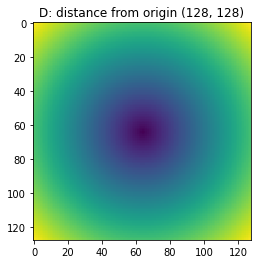

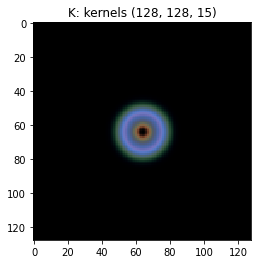

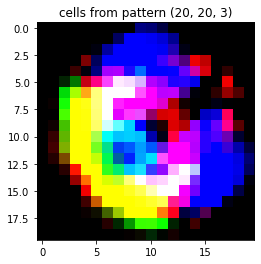

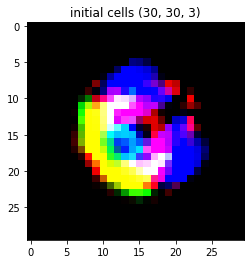

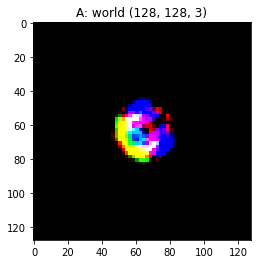

In [ ]:
#@title Load pattern

pattern_id = "5N7KKM"

bell = lambda x, mean, stdev: jnp.exp(-((x-mean)/stdev)**2 / 2)
growth = lambda x, mean, stdev: bell(x, mean, stdev) * 2 - 1

def create_world_from_cells(cells):
  global world_size, world_scale
  mid = world_size // 2
  scaled_cells = cells.repeat(world_scale, axis=-3).repeat(world_scale, axis=-2)
  cy, cx = scaled_cells.shape[0], scaled_cells.shape[1]
  A = jnp.zeros([world_size, world_size, 3])  # (y,x,c)
  A = A.at[mid-cx//2:mid+cx-cx//2, mid-cy//2:mid+cy-cy//2, :].set(scaled_cells)
  return A

def load_pattern(pattern):
  global n_params_size, n_cell_size, n_kernel, n_channel, n_params, n_cells, n_gene, \
      world_size, world_scale

  cells = jnp.transpose(jnp.asarray(pattern['cells']), axes=[1, 2, 0])  # (y,x,c)
  kernels = pattern['kernels']
  R = pattern['R'] * world_scale
  T = pattern['T']
  n_kernel = len(kernels)  # k
  n_channel = cells.shape[-1]  # c
  n_params = n_params_size * n_kernel  # 3*k
  n_cells = n_cells_size * n_cells_size * n_channel  # e*e*c
  n_gene = n_params + n_cells

  # get params from pattern (to be put in gene)
  m = jnp.array([ k['m'] for k in kernels ])  # (k)
  s = jnp.array([ k['s'] for k in kernels ])  # (k)
  h = jnp.array([ k['h'] for k in kernels ])  # (k)
  init_params = jnp.vstack([m, s, h])  # (p,k)

  # get reshaping arrays (unfold and fold)
  reshape_c_k = jnp.zeros(shape=(n_channel, n_kernel))  # (c,k)
  reshape_k_c = jnp.zeros(shape=(n_kernel, n_channel))  # (k,c)
  for i, k in enumerate(kernels):
    reshape_c_k = reshape_c_k.at[k['c0'], i].set(1.0)
    reshape_k_c = reshape_k_c.at[i, k['c1']].set(1.0)

  # calculate kernels
  mid = world_size // 2
  X = jnp.mgrid[-mid:mid, -mid:mid] / R  # (d,y,x)
  D = jnp.linalg.norm(X, axis=0)  # (y,x)
  Ds = [ D * len(k['b']) / k['r'] for k in kernels ]  # (y,x)*k
  Ks = [ (D<len(k['b'])) * jnp.asarray(k['b'])[jnp.minimum(D.astype(int),len(k['b'])-1)] * bell(D%1, 0.5, 0.15) for D,k in zip(Ds,kernels) ]  # (x,y)*k
  K = jnp.dstack(Ks)  # (y,x,k)
  nK = K / jnp.sum(K, axis=(0,1), keepdims=True)  # (y,x,k)
  fK = jnp.fft.fft2(jnp.fft.fftshift(nK, axes=(0,1)), axes=(0,1))  # (y,x,k)

  # pad pattern cells into initial cells (to be put in gene)
  cy, cx = cells.shape[0], cells.shape[1]
  py, px = n_cells_size - cy, n_cells_size - cx
  init_cells = jnp.pad(cells, pad_width=((py//2, py-py//2), (px//2, px-px//2), (0,0)), mode='constant')  # (e,e,c)

  # create world from initial cells
  A = create_world_from_cells(init_cells)

  init_carry = Carry(
      world = A, 
      param = Param(m, s, h), 
      asset = Asset(fK, X, reshape_c_k, reshape_k_c, R, T), 
      center = Center(jnp.zeros(2), jnp.zeros(2, dtype=int), jnp.zeros(2, dtype=int)))
  init_gene = jnp.concatenate([ init_params.flatten(), init_cells.flatten() ])
  other_asset = Others(D, K, cells, init_cells)
  return init_carry, init_gene, other_asset

# load pattern
pattern = patterns[pattern_id]
print(f"Loading pattern['{pattern_id}'] = {pattern['name']} ...")
init_carry, init_gene, other_asset = load_pattern(pattern)

# print it out
print(f"{n_kernel=}, {n_channel=}, {n_params=}, {n_cells=}, {n_gene=}")
print(f"{init_carry.param.m.shape=}\n{init_carry.param.s.shape=}\n{init_carry.param.h.shape=}")
print(f"{init_carry.param.m=}")
print(f"{init_carry.asset.reshape_c_k.shape=}\n{init_carry.asset.reshape_k_c.shape=}")
print(f"{init_gene.shape=}")
# print(f"{X.shape=}\n{D.shape=}\n{K.shape=}\n{nK.shape=}\n{fK.shape=}")
# print(f"{cells.shape=}\n{init_cells.shape=}\n{scaled_cells.shape=}\n{A.shape=}")
display_array(other_asset.D, f"D: distance from origin {other_asset.D.shape}")
K_combined = jnp.dot(other_asset.K, init_carry.asset.reshape_k_c) / 5.0
display_array(K_combined, f"K: kernels {other_asset.K.shape}")
display_array(other_asset.cells, f"cells from pattern {other_asset.cells.shape}")
display_array(other_asset.init_cells, f"initial cells {other_asset.init_cells.shape}")
display_array(init_carry.world, f"A: world {init_carry.world.shape}")


In [ ]:
#@title Express gene

# will replace carry.world & carry.gene
@jax.jit
def express_gene(carry, gene):
  global n_params_size, n_cells_size, n_kernel, n_channel, n_params, n_cells, n_gene, \
      world_size, world_scale
      
  params = gene[:n_params].reshape((n_params_size, n_kernel))
  cells = gene[n_params:].reshape((n_cells_size, n_cells_size, n_channel))

  A = create_world_from_cells(cells)

  carry = carry._replace(world=A)
  m, s, h = params
  carry = carry._replace(param=Param(m, s, h))
  return carry

# unit test
_carry = express_gene(init_carry, init_gene)
display_array(_carry.world, f"A: world {_carry.world.shape}")
print(f"{_carry.param.m.shape=}")
print(f"{_carry.param.m=}")


In [ ]:
#@title Step
# will replace carry.world & carry.center
def step(carry:Carry, e, is_record=True):
  A = carry.world
  m, s, h = carry.param
  fK, X, reshape_c_k, reshape_k_c, R, T = carry.asset
  last_center, last_shift, total_shift = carry.center
  m = m[None, None, ...]  # (1,1,k)
  s = s[None, None, ...]  # (1,1,k)
  h = h[None, None, ...]  # (1,1,k)

  A = jnp.roll(A, -last_shift, axis=(-3, -2))  # (y,x,c)
  fA = jnp.fft.fft2(A, axes=(-3, -2))  # (y,x,c)
  fA_k = jnp.dot(fA, reshape_c_k)  # (y,x,k)
  U_k = jnp.real(jnp.fft.ifft2(fK * fA_k, axes=(-3, -2)))  # (y,x,k)
  G_k = growth(U_k, m, s) * h  # (y,x,k)
  G = jnp.dot(G_k, reshape_k_c)  # (y,x,c)
  next_A = jnp.clip(A + 1/T * G, 0, 1)  # (y,x,c)

  AX = next_A.sum(axis=-1)[None, ...] * X  # (d,y,x)
  center = AX.sum(axis=(-2, -1)) / A.sum()  # (d)
  shift = (center * R).astype(int)
  total_shift += shift

  carry = carry._replace(world=next_A)
  carry = carry._replace(center=Center(center, shift, total_shift))

  if is_record:
    actual_A = jnp.roll(next_A, total_shift - shift, axis=(0,1))
  else:
    actual_A = 0
  actual_center = center + total_shift / R
  speed = jnp.linalg.norm(center - last_center + last_shift / R) * T
  is_empty = (next_A < 0.1).all(axis=(-3, -2)).any()
  borders = next_A[...,0,:,:].sum() + next_A[...,-1,:,:].sum() + next_A[...,:,0,:].sum() + next_A[...,:,-1,:].sum()
  is_full = borders > 0.1
  accum = Accum(actual_A, Stats(actual_center[1], -actual_center[0], speed, is_empty, is_full))
  return carry, accum

step_no_record = partial(step, is_record=False)

# unit test
test = 0
if (test == 1):
  # test for loop
  _gene = copy.deepcopy(np.asarray(init_gene))
  _gene[0] = 0
  # gene = init_gene
  _carry = express_gene(init_carry, _gene)
  for i in range(n_sim):
    _carry, _accum = step(_carry, i)
  display_array(_accum.world, "A final")
elif (test == 2):
  # test jax.lax.scan step_no_record
  _jit_step_no_record = jax.jit(partial(step, is_record=False))
  _gene = copy.deepcopy(np.asarray(init_gene))
  _gene[0] = 0
  _carry = express_gene(init_carry, _gene)
  _carry, _accum = jax.lax.scan(_jit_step_no_record, init=_carry, xs=np.arange(n_sim))
  display_array(_carry.world, "A final centered")
  _speed = _accum.stats.speed
  _avg_speed = sum(_speed[50:]) / len(_speed[50:])
  print("fitness = ", _avg_speed)
  print("0 if world not recorded: ", _accum.world[0])
elif (test == 3):
  # test jax.lax.scan
  _jit_step_do_record = jax.jit(partial(step, is_record=True))
  _gene = copy.deepcopy(np.asarray(init_gene))
  # _gene[4] = 0.1  #is_full
  # _gene[4] = 0  #is_empty
  _carry = express_gene(init_carry, _gene)
  _carry, _accum = jax.lax.scan(_jit_step_do_record, init=_carry, xs=np.arange(n_sim))
  _speed = _accum.stats.speed
  _avg_speed = sum(_speed[50:]) / len(_speed[50:])
  print("fitness = ", _avg_speed)
  display_video(_accum.world)
  plt.plot(_accum.stats.speed, label='speed')
  plt.plot(_accum.stats.is_empty, label='is_empty')
  plt.plot(_accum.stats.is_full, label='is_full')
  plt.legend()
  plt.show()


In [ ]:
#@title Evaluate & simulate

def evaluate(gene):
  global n_sim
  carry = express_gene(init_carry, gene)
  carry, accum = jax.lax.scan(step_no_record, init=carry, xs=np.arange(n_sim))
  dead = jnp.logical_or(accum.stats.is_empty.any(), accum.stats.is_full.any())
  speed = accum.stats.speed
  avg_speed = sum(speed[50:]) / len(speed[50:])
  fitness = jax.lax.cond(dead, lambda: 0.0, lambda: avg_speed)
  return fitness

# evaluate_batch = jax.vmap(evaluate, in_axes=(0,), out_axes=0)
evaluate_batch = jax.experimental.maps.xmap(evaluate, in_axes=(['b', ...], ), out_axes=['b', ...])

def simulate(gene):
  global n_sim
  carry = express_gene(init_carry, gene)
  carry, accum = jax.lax.scan(step, init=carry, xs=np.arange(n_sim))
  dead = jnp.logical_or(accum.stats.is_empty.any(), accum.stats.is_full.any())
  speed = accum.stats.speed
  avg_speed = sum(speed[50:]) / len(speed[50:])
  fitness = jax.lax.cond(dead, lambda: 0.0, lambda: avg_speed)
  return accum, fitness

# unit tests
test = 0
if (test == 1):
  # text evaluate
  _gene = copy.deepcopy(np.asarray(init_gene))
  # _gene[4] = 0  # 0
  # _gene[0] = 0  # 0.03094454
  # 0.06990926
  _fitness = evaluate(_gene)
  print("fitness = ", _fitness)
elif (test == 2):
  # text evaluate_batch
  _ms = jax.random.normal(key=jax.random.PRNGKey(42), shape=(n_population, ))
  _ms = (_ms - 0.5) / 5
  _gene = copy.deepcopy(np.asarray(init_gene))
  _genes = np.repeat(_gene[None, ...], n_population, axis=0)
  _genes[:, 4] += _ms
  _fitnesses = evaluate_batch(_genes)
  print("fitnesses = ", _fitnesses)
elif (test == 3):
  # text simulate
  _gene = copy.deepcopy(np.asarray(init_gene))
  # _gene[4] = 0.1  #is_full
  # _gene[4] = 0  #is_empty
  _accum, _fitness = simulate(_gene)
  print("fitness = ", _fitness)
  display_video(_accum.world)


In [ ]:
#@title Run CMA-ES

solver = evojax.algo.CMA_ES_JAX(
    pop_size=n_population,
    param_size=n_gene,
    mean=init_gene,
    init_stdev=0.01,
)

fitness_series = []
frames_series = []
for iter in range(n_iteration):
  genes = solver.ask()  # (pop, gene)
  fitnesses = evaluate_batch(genes)  # (pop)
  solver.tell(fitnesses)

  if iter % n_interval == 0 or iter == n_iteration:
    best_gene = solver.best_params  # (gene)
    best_fitness = evaluate(best_gene)
    print(f"iteration #{iter:02d}: best fitness = {best_fitness:0.4f}")
    fitness_series.append(best_fitness)
    accum, fitness = simulate(best_gene)
    frames_series.append(accum.world)


iteration #00: best fitness = 0.0952
iteration #01: best fitness = 0.1088
iteration #02: best fitness = 0.1248
iteration #03: best fitness = 0.1337
iteration #04: best fitness = 0.1598
iteration #05: best fitness = 0.1636
iteration #06: best fitness = 0.1863
iteration #07: best fitness = 0.1787
iteration #08: best fitness = 0.1841
iteration #09: best fitness = 0.2041
iteration #10: best fitness = 0.2379
iteration #11: best fitness = 0.2211
iteration #12: best fitness = 0.2082
iteration #13: best fitness = 0.2243
iteration #14: best fitness = 0.2235
iteration #15: best fitness = 0.2151
iteration #16: best fitness = 0.2233
iteration #17: best fitness = 0.2261
iteration #18: best fitness = 0.2313
iteration #19: best fitness = 0.2348
iteration #20: best fitness = 0.2422
iteration #21: best fitness = 0.2486
iteration #22: best fitness = 0.2443
iteration #23: best fitness = 0.2502
iteration #24: best fitness = 0.2498
iteration #25: best fitness = 0.2399
iteration #26: best fitness = 0.2372
i

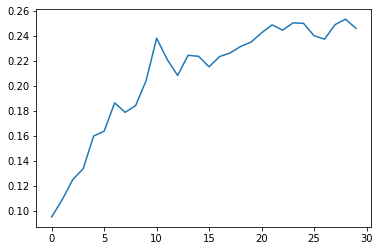

Initial fitness =  0.06990925


Best fitness =  0.24576624


In [ ]:
#@title Progress chart and best result

plt.plot(fitness_series)
plt.show()

init_accum, init_fitness = simulate(init_gene)
print("Initial fitness = ", init_fitness)
display_video(init_accum.world[-100:], step=1, title=f"fitness={init_fitness:0.4f}")

best_accum, best_fitness = simulate(best_gene)
print("Best fitness = ", best_fitness)
display_video(best_accum.world[-100:], step=1, title=f"fitness={best_fitness:0.4f}")


In [ ]:
#@title Show all results

for world, fitness in zip(frames_series, fitness_series):
  display_video(world[-50:], step=1, title=f"fitness={fitness:0.4f}")

# all_frames = np.asarray(frames_series)
# all_frames = all_frames.reshape((-1,) + all_frames.shape[-3:])
# display_video(all_frames)
